In [1]:
# import the needed libraries
import numpy as np
import pickle
import cv2
import math
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

print("done")

done


In [34]:
EPOCHS = 5 #50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256,256))
image_size = 0
directory_root = './input/plantvillage'
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Soybean___healthy ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Tomato_mosaic_virus .

In [4]:
image_size = len(image_list)
image_size

4152

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Orange___Haunglongbing_(Citrus_greening)'
 'Pepper,_bell___Bacterial_spot' 'Pepper,_bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Soybean___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


In [6]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Splitting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.3, random_state = 42)

[INFO] Splitting data to train, test


In [7]:
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# ***5 Layer CNN Algorithm ***

In [8]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation(tf.nn.relu))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation(tf.nn.softmax))
# summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

### graphical view of the model

In [9]:
# graphical view of the model
plot_model(model, to_file='cn_basic_cnn_architecture.png',dpi=1000, show_shapes=True, show_layer_names=True)

# Optimizer

In [10]:
# optimizer
opt = Adam(
    learning_rate=INIT_LR,
    decay=INIT_LR / EPOCHS
)
# distribution
model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)
# train the network
print("[INFO] training network...")

[INFO] training network...


In [11]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=5, # 50,
    verbose=1
)

Epoch 1/5
90/90 [==============================] - 355s 4s/step - loss: 0.1534 - accuracy: 0.3932 - val_loss: 0.8117 - val_accuracy: 0.0433
Epoch 2/5
90/90 [==============================] - 379s 4s/step - loss: 0.1142 - accuracy: 0.5564 - val_loss: 0.7211 - val_accuracy: 0.0433
Epoch 3/5
90/90 [==============================] - 329s 4s/step - loss: 0.0957 - accuracy: 0.6308 - val_loss: 0.5766 - val_accuracy: 0.0602
Epoch 4/5
90/90 [==============================] - 317s 4s/step - loss: 0.0792 - accuracy: 0.6872 - val_loss: 0.2763 - val_accuracy: 0.2512
Epoch 5/5
90/90 [==============================] - 311s 3s/step - loss: 0.0743 - accuracy: 0.7105 - val_loss: 0.3320 - val_accuracy: 0.2151


### Results and plots

c:\Users\musah\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\musah\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\musah\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\musah\Anacond

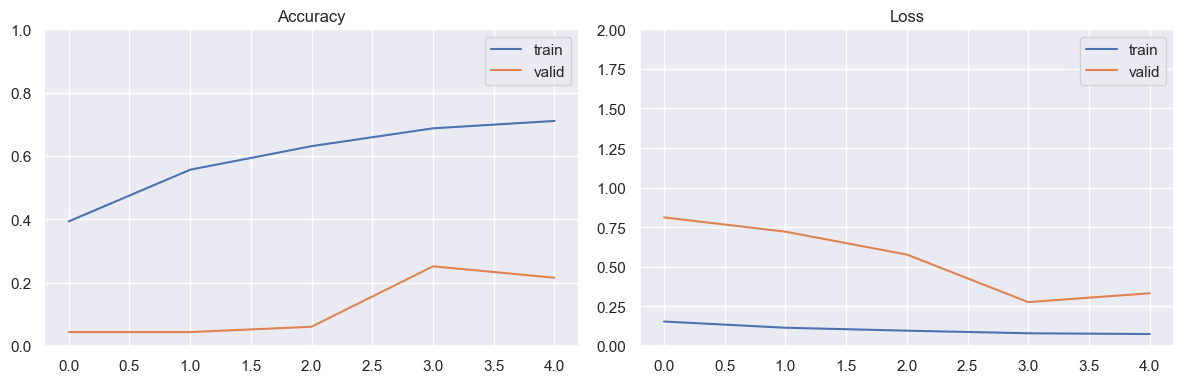

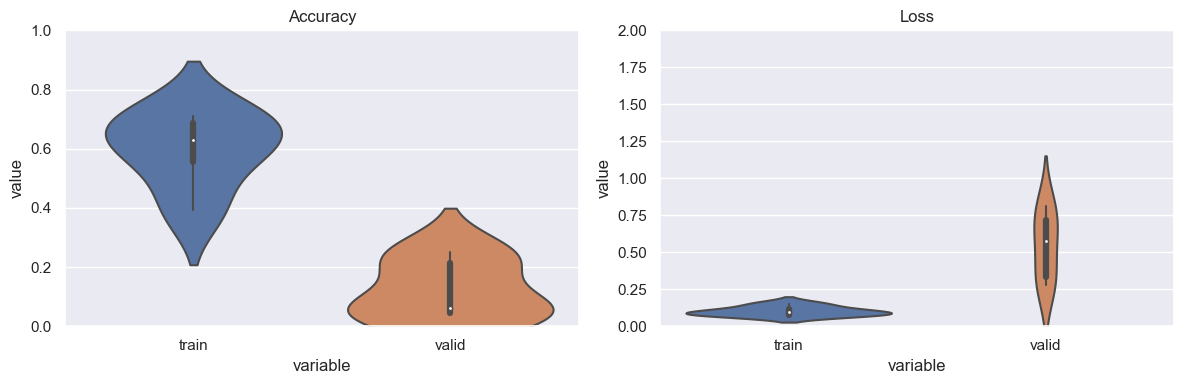

[INFO] Calculating model accuracy
39/39 [==============================] - 24s 620ms/step - loss: 0.3320 - accuracy: 0.2151
Test Accuracy: 21.508827805519104


In [12]:
import scikitplot
import seaborn as sns
from matplotlib import pyplot
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.ylim([0, 1])
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
plt.ylim([0, 2])
pyplot.tight_layout()

pyplot.savefig('cn_epoch_history_basic_CNN.png',dpi=1000)
pyplot.show()

df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (12, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
plt.ylim([0, 1])
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
plt.ylim([0, 2])
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('cnn_performance_BASIC_CNN.png',dpi=1000)
pyplot.show()


print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn import metrics


def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual.argmax(axis=1), predicted.argmax(axis=1))
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(20, 15))
    sns.heatmap(
        cm_df, annot=True,  fmt='.2f',
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('basiccnn.png', bbox_inches='tight', dpi=1000)
    plt.show()


91/91 [==============================] - 58s 635ms/step
              precision    recall  f1-score   support

           0       0.14      0.96      0.25       130
           1       1.00      0.04      0.09       134
           2       0.29      0.38      0.33       146
           3       1.00      0.04      0.07       133
           4       0.25      0.68      0.37       141
           5       0.00      0.00      0.00       131
           6       0.00      0.00      0.00       142
           7       1.00      0.01      0.01       134
           8       0.08      0.01      0.02       143
           9       0.73      0.30      0.43       105
          10       0.95      0.14      0.24       143
          11       0.23      0.90      0.37       133
          12       0.00      0.00      0.00       135
          13       0.44      0.07      0.12       152
          14       0.33      0.01      0.01       139
          15       1.00      0.01      0.03       152
          16       0.21  

c:\Users\musah\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\musah\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


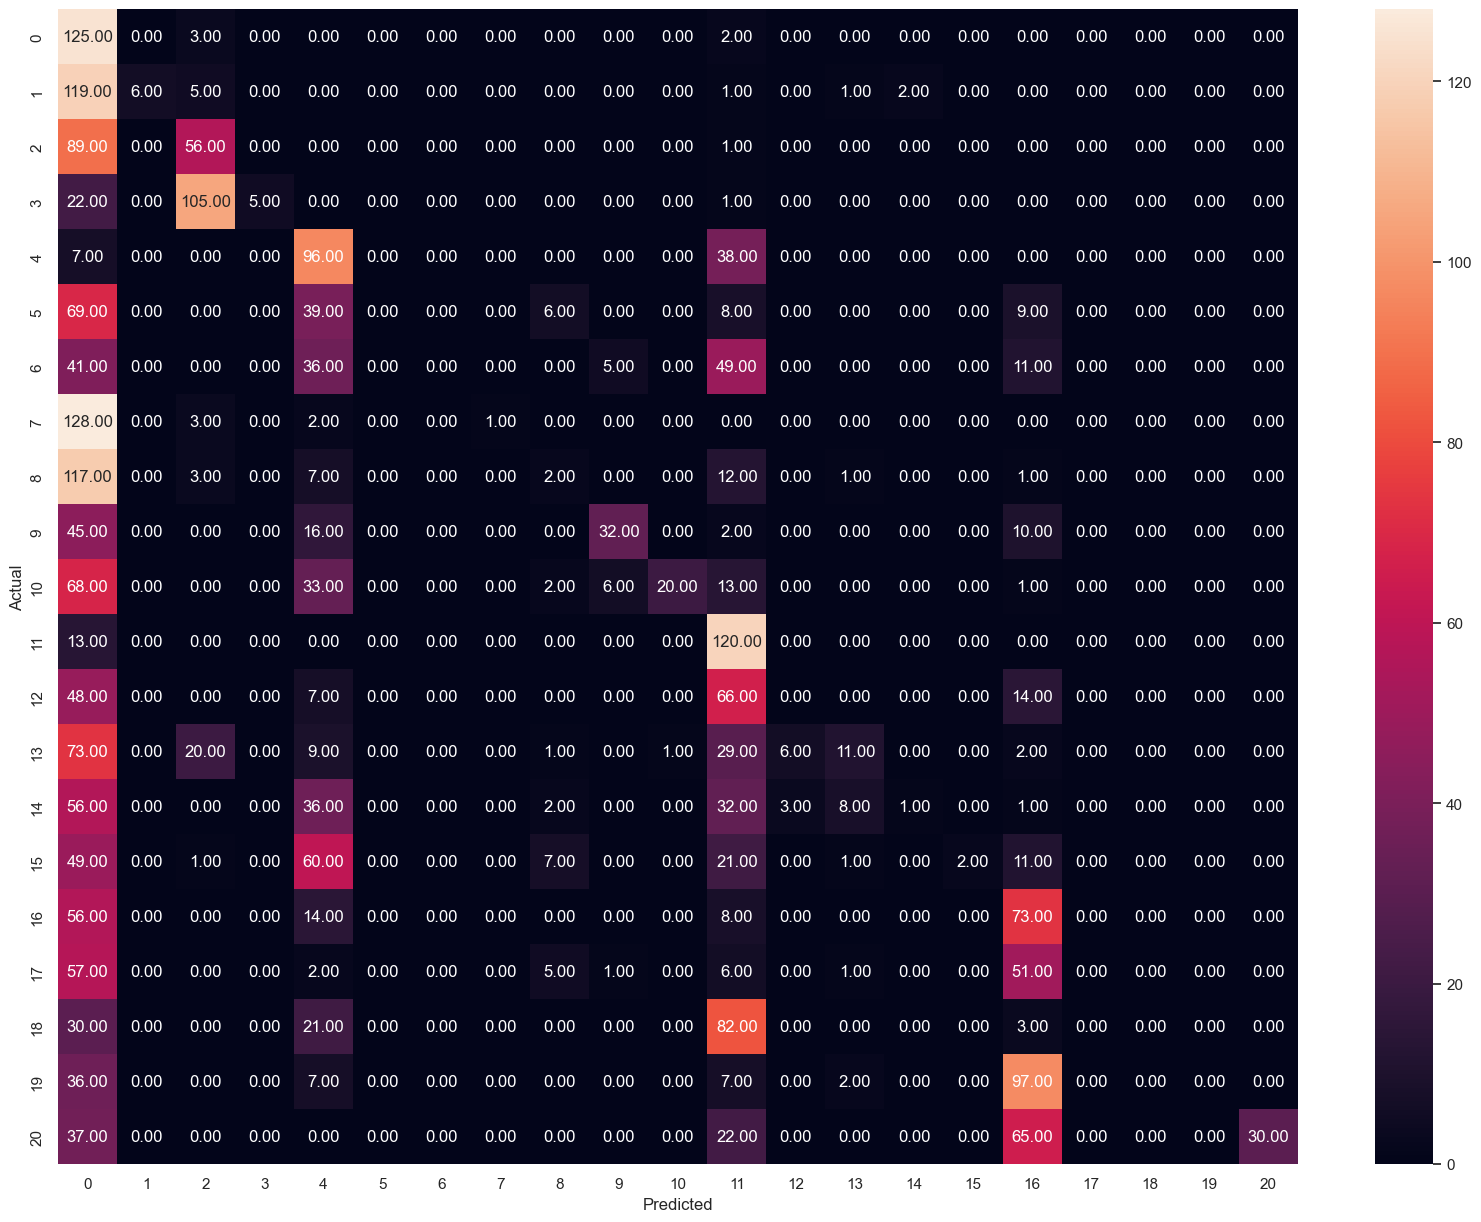

In [31]:
y_pred_train1 = model.predict(x_train)
y_pred = (y_pred_train1 > 0.5) 
np.argmax(y_pred, axis=1)
metrics_score(y_train, y_pred)

# Inception model V3


### Weights : Imagenet

In [32]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False

# Compile
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()


87910968/87910968 [==============================] - 11s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 127, 127, 32  96         ['conv2d_5[0][0]']               
 rmalization)               

## Plot the model

In [37]:
plot_model(model, to_file='inceptionv3_architucture.png',dpi=1000, show_shapes=True, show_layer_names=True)

In [36]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
)

Epoch 1/5
90/90 [==============================] - 269s 3s/step - loss: 0.1481 - accuracy: 0.4141 - val_loss: 0.0918 - val_accuracy: 0.6188
Epoch 2/5
90/90 [==============================] - 251s 3s/step - loss: 0.0815 - accuracy: 0.6747 - val_loss: 0.0669 - val_accuracy: 0.7520
Epoch 3/5
90/90 [==============================] - 251s 3s/step - loss: 0.0635 - accuracy: 0.7568 - val_loss: 0.0622 - val_accuracy: 0.7584
Epoch 4/5
90/90 [==============================] - 249s 3s/step - loss: 0.0570 - accuracy: 0.7878 - val_loss: 0.0604 - val_accuracy: 0.7705
Epoch 5/5
90/90 [==============================] - 250s 3s/step - loss: 0.0524 - accuracy: 0.8024 - val_loss: 0.0562 - val_accuracy: 0.7873


c:\Users\musah\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\musah\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\musah\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\musah\Anacond

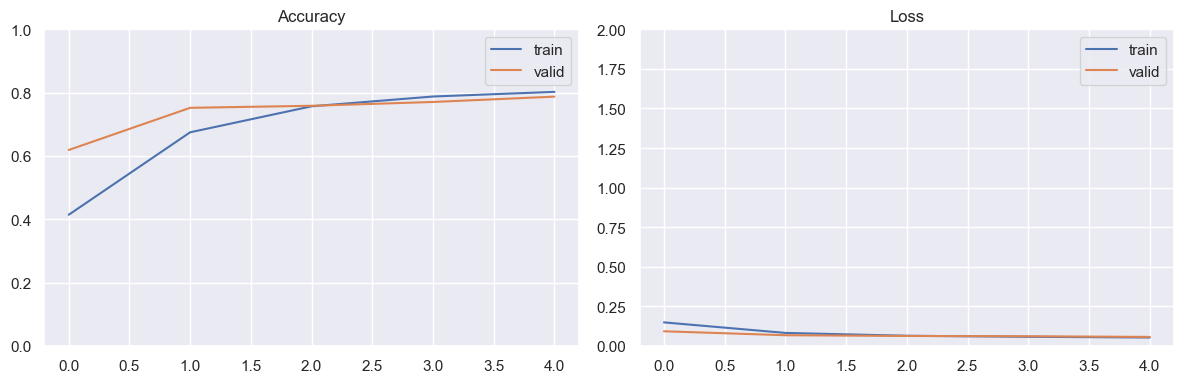

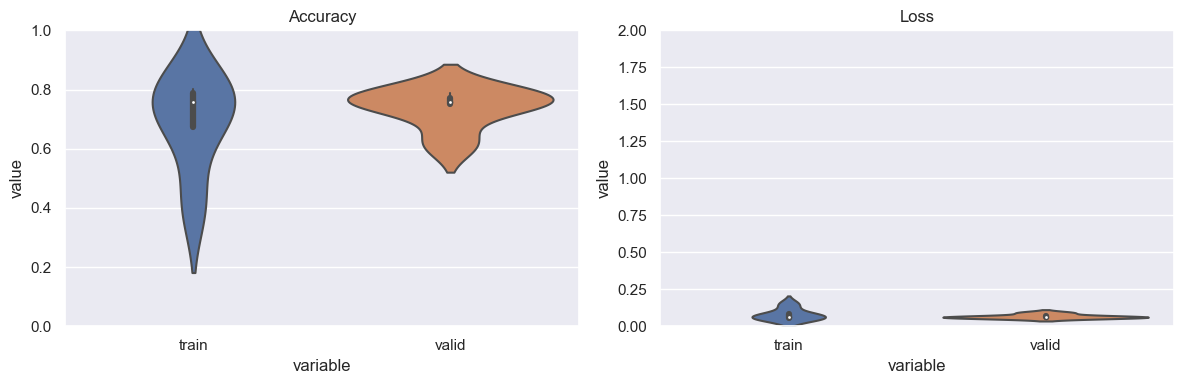

[INFO] Calculating model accuracy
39/39 [==============================] - 80s 2s/step - loss: 0.0562 - accuracy: 0.7873
Test Accuracy: 78.73194217681885


In [38]:
import scikitplot
import seaborn as sns
from matplotlib import pyplot
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
plt.ylim([0, 1])
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
plt.ylim([0, 2])
pyplot.tight_layout()

pyplot.savefig('9_epoch_history_inpectionv3.png', bbox_inches='tight', dpi=1000)
pyplot.show()

df_accu = pd.DataFrame(
    {'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame(
    {'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (12, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value",data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
plt.ylim([0, 1])
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
plt.ylim([0, 2])
pyplot.tight_layout()

pyplot.savefig('9_performance_Inceptionv3.png', bbox_inches='tight', dpi=1000)
pyplot.show()


print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")


91/91 [==============================] - 180s 2s/step
              precision    recall  f1-score   support

           0       0.88      0.62      0.73       130
           1       0.92      1.00      0.96       134
           2       0.79      0.87      0.83       146
           3       0.99      0.99      0.99       133
           4       0.97      0.99      0.98       141
           5       0.90      0.82      0.86       131
           6       0.91      0.89      0.90       142
           7       0.91      0.93      0.92       134
           8       0.93      0.68      0.79       143
           9       0.94      0.75      0.84       105
          10       0.93      0.98      0.95       143
          11       0.81      0.70      0.75       133
          12       0.70      0.61      0.65       135
          13       0.83      0.81      0.82       152
          14       0.92      0.52      0.66       139
          15       0.81      0.68      0.74       152
          16       0.78    

c:\Users\musah\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


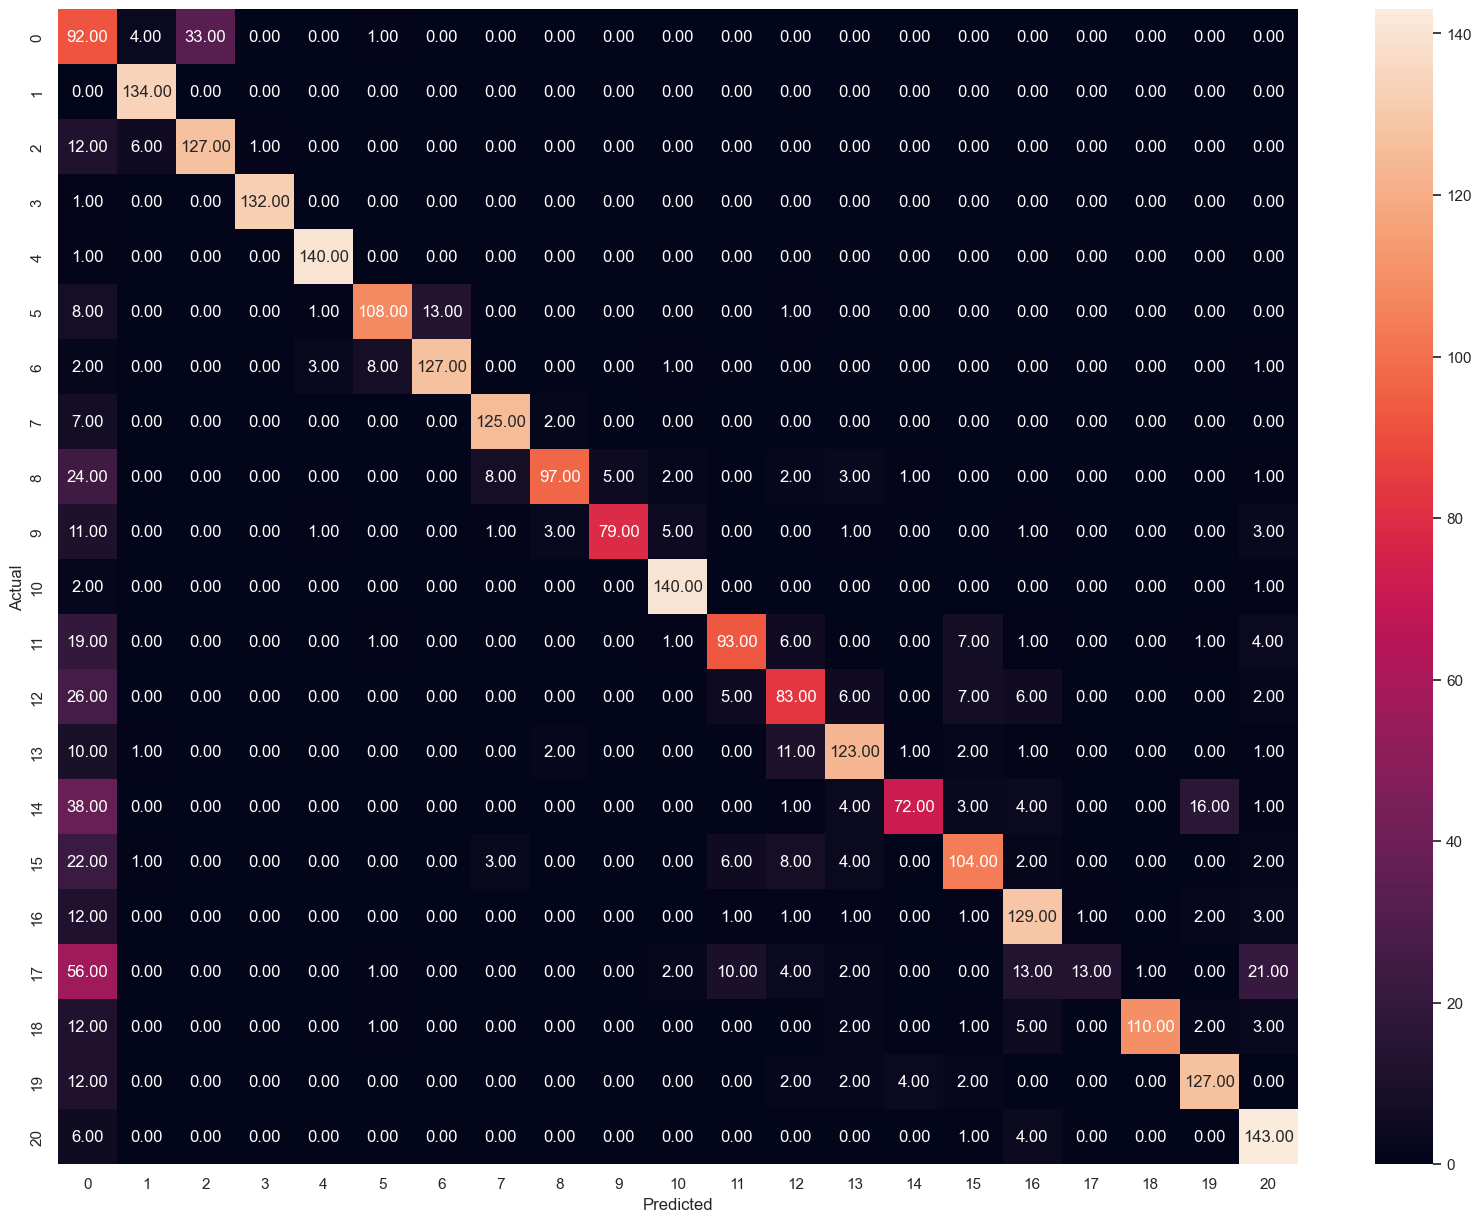

In [39]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual.argmax(axis=1), predicted.argmax(axis=1))
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(20,15))
    sns.heatmap(cm_df, annot=True,  fmt='.2f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('Inceptionv3.png',bbox_inches='tight',dpi=1000)
    plt.show()
y_pred_train2 = model.predict(x_train)
y_pred2 = (y_pred_train2 > 0.5) 
np.argmax(y_pred2, axis=1)
metrics_score(y_train,y_pred2)

# Resnet model

## Weight : Imagenet